In [1]:
import numpy as np
import mne
import os
import json
from matplotlib import pyplot as plt
import git

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
ica_corr_dir = os.path.join(base_dir, 'data', 'ica', 'corr_criterium')
snr_thres_list = [30, 25, 20, 17, 15, 12.5, 10, 7.5, 5, 0]

In [3]:
subjects = list(range(102,115))
subjects = subjects + list(range(116,117))
subjects = subjects + list(range(118,126))
subjects = subjects + [127, 128, 130]
trials = list(range(1, 21))

In [4]:
n_rejected_list_5ms = []
n_rejected_list_1s = []
for subj in subjects:
    n_rejected_subj_5ms = []
    n_rejected_subj_1s = []
    peak_json_dir_5ms = os.path.join(ica_corr_dir, str(subj), f'subj{str(subj)}_SNR_analysis.json')
    peak_json_dir_1s = os.path.join(ica_corr_dir, str(subj), f'subj{str(subj)}_peak_channels.json')
    for peak_json_dir, n_rejected_list in zip([peak_json_dir_5ms, peak_json_dir_1s], [n_rejected_list_5ms, n_rejected_list_1s]):
        n_rejected_subj = []
        with open(peak_json_dir, 'r') as f:
            peak_channels = json.load(f)
            for trial in trials:
                n_rejected_trial = []
                for snr_thres in snr_thres_list:
                    snrs = peak_channels[f'trial_{str(trial)}']['snr']
                    snrs = np.array(snrs)
                    peaking_channels = np.where(snrs > snr_thres)[0]
                    peaking_channels = list(peaking_channels)
                    n_rejected = len(peaking_channels)
                    n_rejected_trial.append(n_rejected)
                n_rejected_subj.append(n_rejected_trial)
        n_rejected_list.append(n_rejected_subj)

## Plot mean number of rejected components for different SNR thresholds

In [5]:
n_mean_rejected_5ms = np.mean(n_rejected_list_5ms, axis=(0,1))
n_std_rejected_5ms = np.std(n_rejected_list_5ms, axis=(0,1))

n_mean_rejected_1s = np.mean(n_rejected_list_1s, axis=(0,1))
n_std_rejected_1s = np.std(n_rejected_list_1s, axis=(0,1))


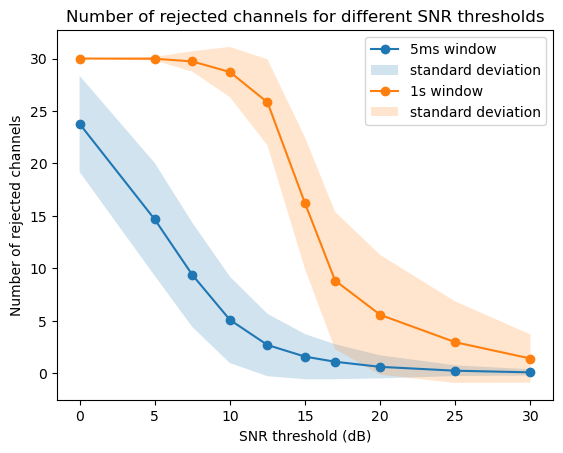

In [7]:
plt.plot(snr_thres_list, n_mean_rejected_5ms, marker='o', label = '5ms window')
plt.fill_between(snr_thres_list, n_mean_rejected_5ms - n_std_rejected_5ms, n_mean_rejected_5ms + n_std_rejected_5ms, alpha=0.2, label = 'standard deviation')

plt.plot(snr_thres_list, n_mean_rejected_1s, marker='o', label = '1s window')
plt.fill_between(snr_thres_list, n_mean_rejected_1s - n_std_rejected_1s, n_mean_rejected_1s + n_std_rejected_1s, alpha=0.2, label = 'standard deviation')


plt.xlabel('SNR threshold (dB)')
plt.ylabel('Number of rejected channels')
plt.title('Number of rejected channels for different SNR thresholds')
plt.legend()

In [9]:
subj_median = np.median(n_rejected_list, axis=(1))
subj_mean = np.mean(n_rejected_list, axis=1)
print(f'subject_mean: {np.mean(subj_mean)}')

subject_mean: 3.715


In [10]:
for db, mean in zip(snr_thres_list, n_mean_rejected_5ms):
    print(f'{db} dB: mean: {mean}')
    print(f'{db} dB: std: {n_std_rejected_5ms[snr_thres_list.index(db)]}')


30 dB: mean: 0.086
30 dB: std: 0.29428557558942636
25 dB: mean: 0.244
25 dB: std: 0.5103567379784452
20 dB: mean: 0.612
20 dB: std: 1.0997526994738467
17 dB: mean: 1.098
17 dB: std: 1.665051350559496
15 dB: mean: 1.586
15 dB: std: 2.1537418601122984
12.5 dB: mean: 2.694
12.5 dB: std: 2.9746199757279976
10 dB: mean: 5.094
10 dB: std: 4.119849997269319
7.5 dB: mean: 9.382
7.5 dB: std: 4.971928800777419
5 dB: mean: 14.668
5 dB: std: 5.377153150134376
0 dB: mean: 23.778
0 dB: std: 4.583962914335151


In [10]:
rejected_25dB = n_rejected_list[:,:,1]
print(f'rejected_25dB_mean: {np.mean(rejected_25dB)}')

rejected_25dB_mean: 0.244


In [11]:
rejected_data = {}
for snr in snr_thres_list:
    rejected_data[f'snr_{snr}dB'] = subj_mean[:, snr_thres_list.index(snr)]
snrs = [f'snr_{snr}dB' for snr in snr_thres_list]

Text(22, 19, 'median: 0.0')

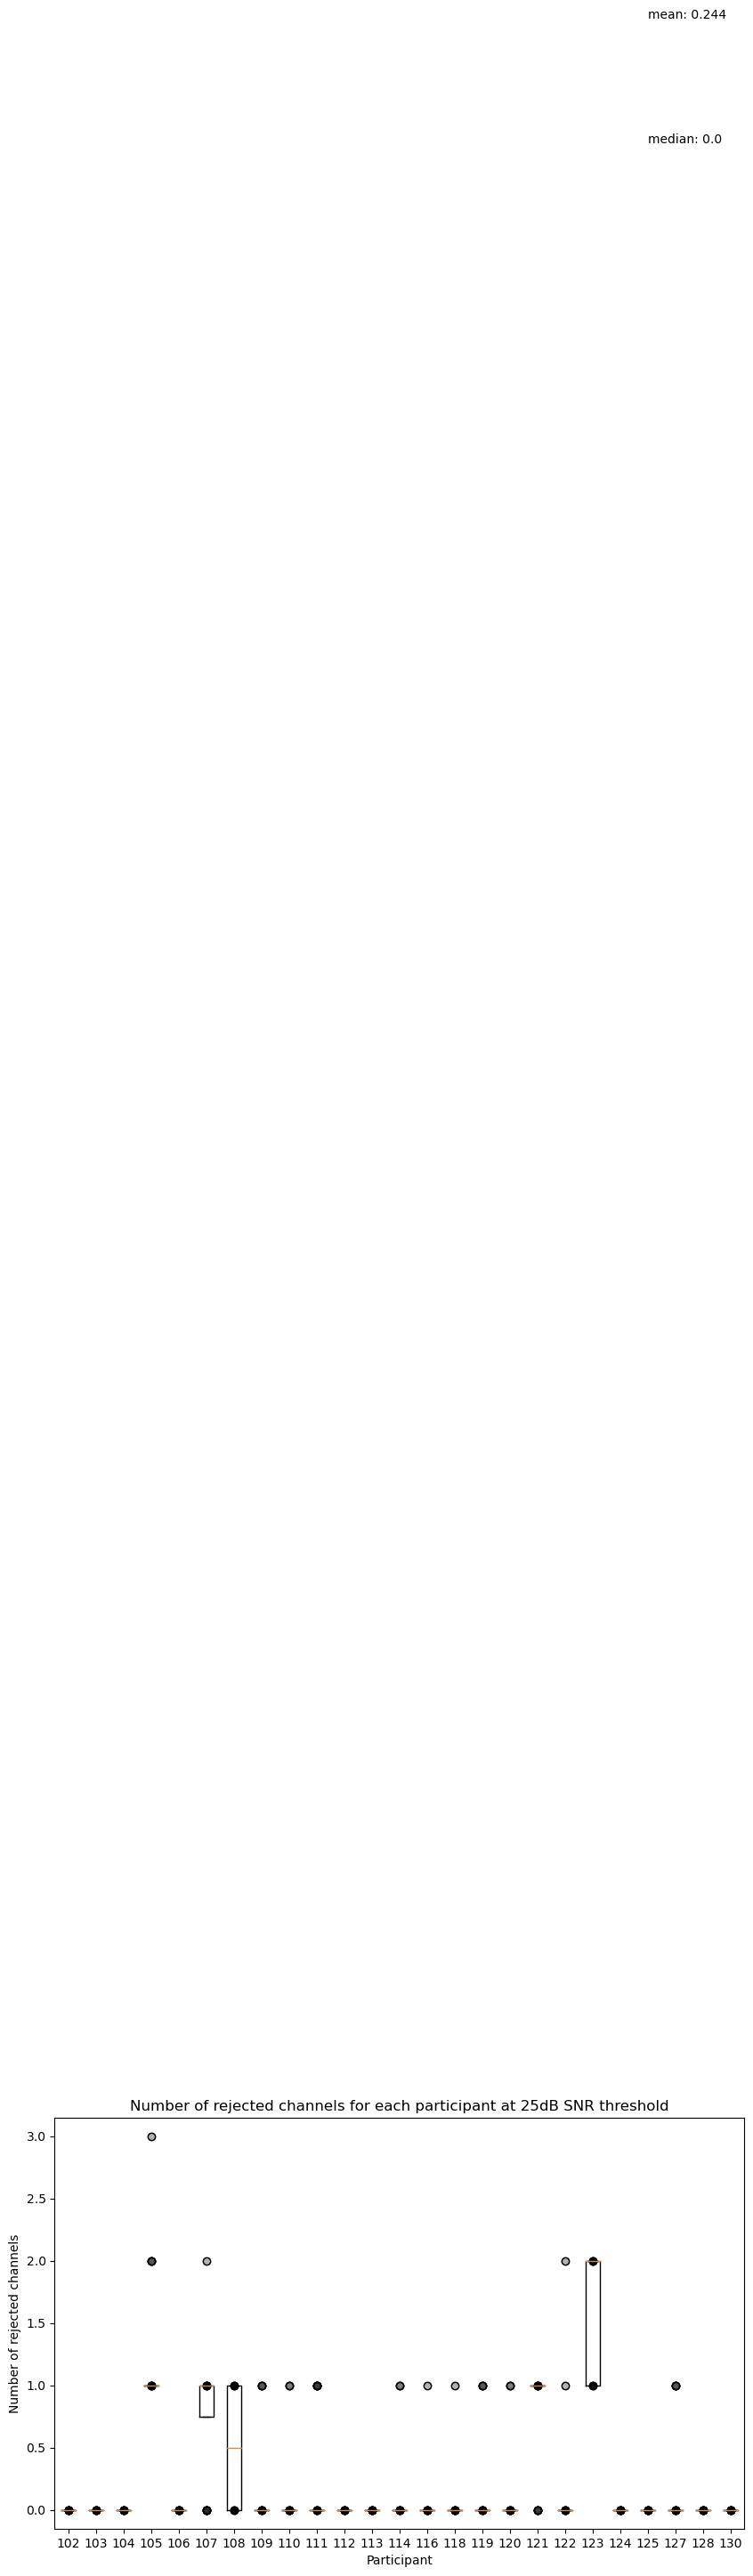

In [12]:
snr_thres = 25
rejected_25dB = n_rejected_list[:, :, snr_thres_list.index(snr_thres)]
# plot the number of rejected channels for each subject as boxplot + scatter
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(rejected_25dB.T)
for i, subj in enumerate(subjects):
    ax.scatter(np.ones(20) * (i + 1), rejected_25dB[i], color='black', alpha=0.3)
ax.set_xticklabels(subjects)
ax.set_xlabel('Participant')
ax.set_ylabel('Number of rejected channels')
ax.set_title(f'Number of rejected channels for each participant at {snr_thres}dB SNR threshold')
ax.text(22,20, f'mean: {np.mean(rejected_25dB)}')
ax.text(22,19, f'median: {np.median(rejected_25dB)}')

### Analyse decrease of the number of rejected components dependent on SNR threshold

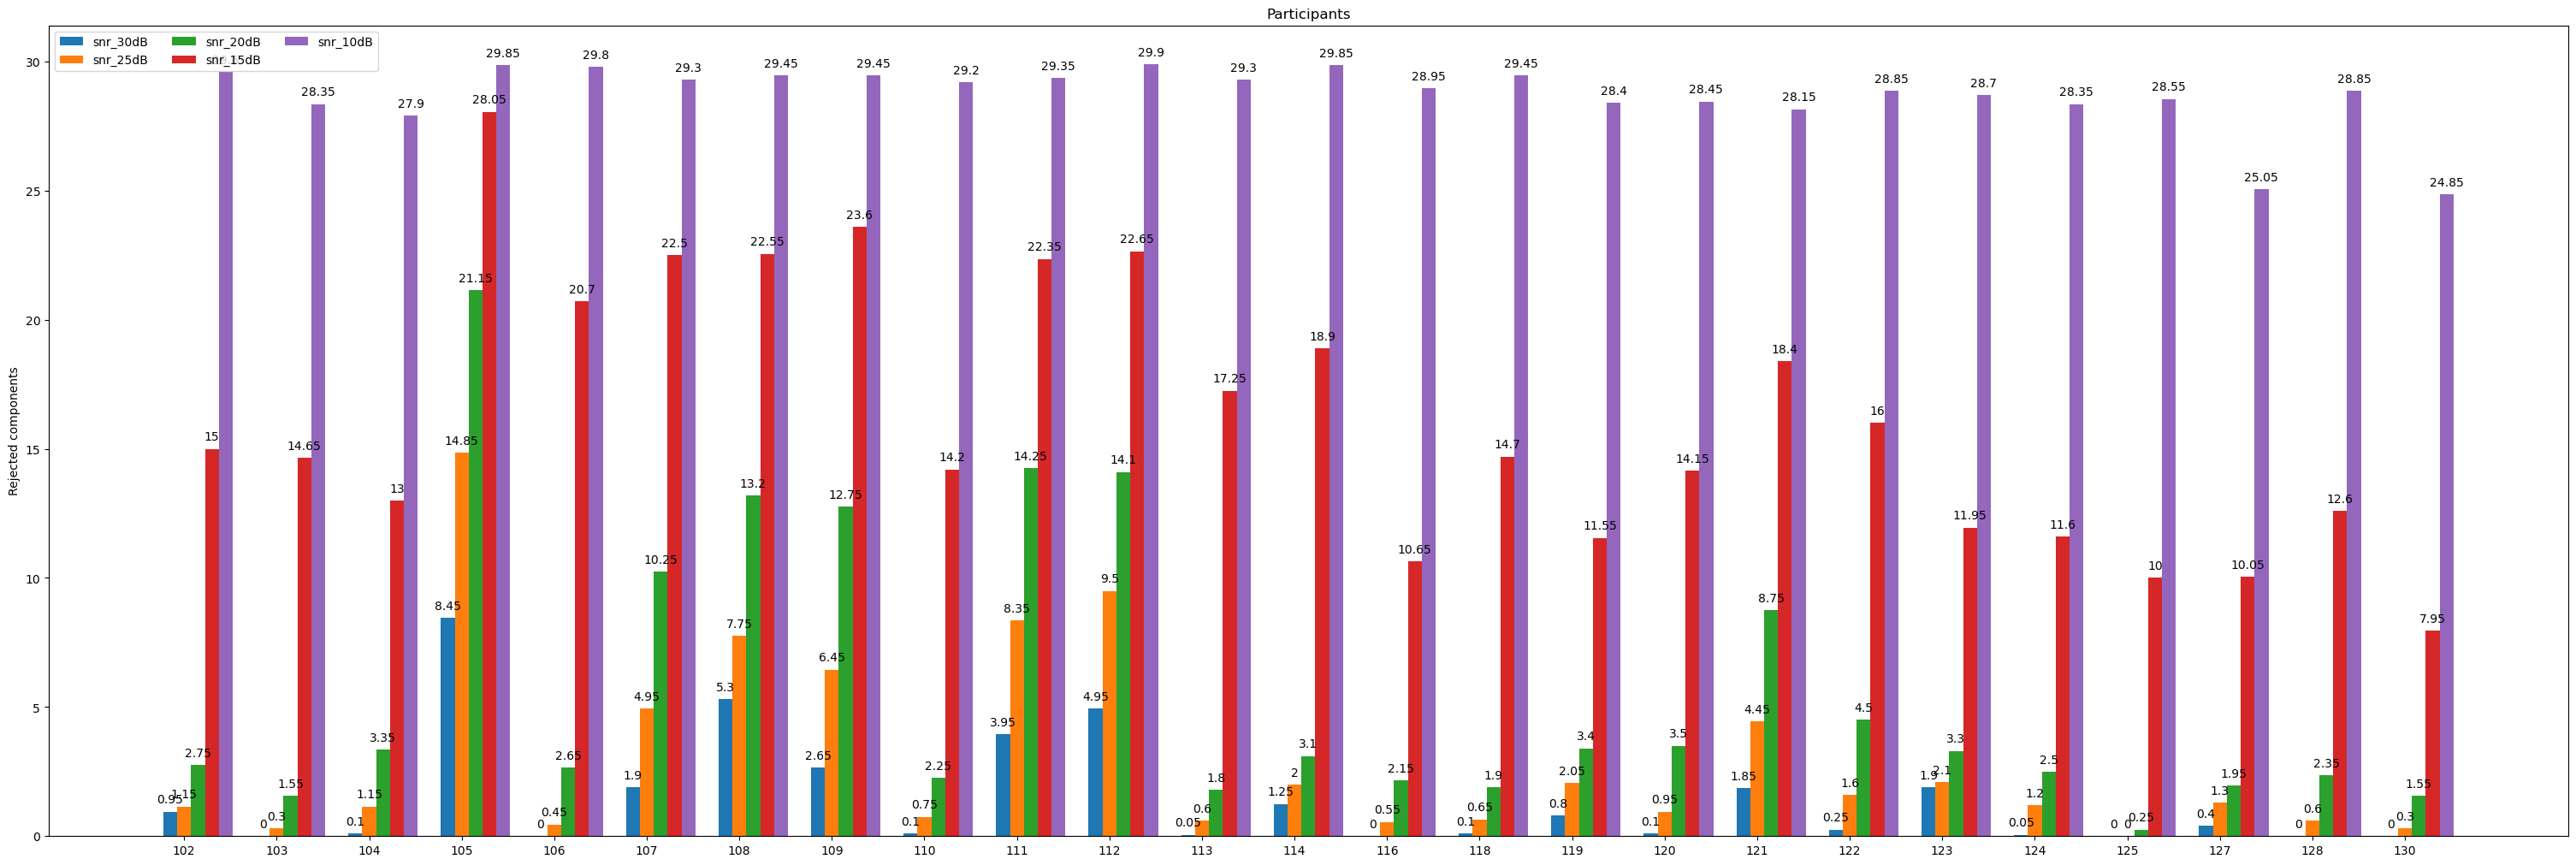

In [40]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(30, 10))

for attribute, measurement in rejected_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rejected components')
ax.set_title('Participants')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(0, 250)

plt.show()

In [47]:
trial_mean_25dB = np.mean(n_rejected_list[:,:,1], axis=0)

Text(0.5, 1.0, 'SNR threshold = 25 dB')

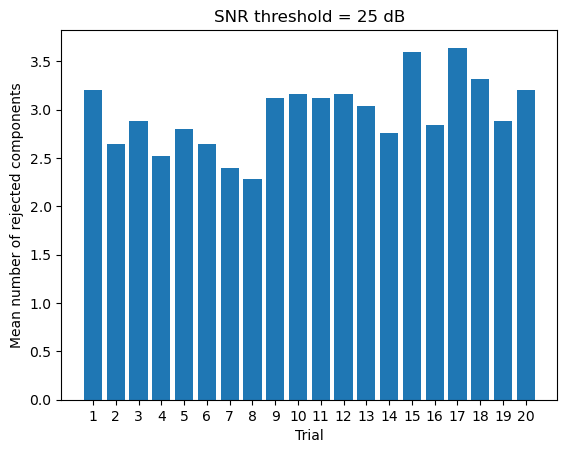

In [50]:
plt.bar(trials, trial_mean_25dB, capsize=5)
plt.xlabel('Trial')
plt.ylabel('Mean number of rejected components')
plt.xticks(trials)
plt.title('SNR threshold = 25 dB')